# 1. Load Modules

In [3]:
import arcpy
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import dates
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import datetime

# 2. Inputs (pull this from notebook 2?)

In [12]:
#date_list = [20220919, 20220920]

start_date = datetime.date(2022,9,19)
end_date = datetime.date(2022,9,19)

date_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
date_list = [date_obj.strftime('%Y%m%d') for date_obj in date_list]

airport_name_list = ['LondonCity']
'''
airport_name_list = ['Heathrow', \
                     'Gatwick', \
                     'Manchester', \
                     'Stansted', \
                     'Edinburgh', \
                     'Birmingham', \
                     'Bristol', \
                     'Glasgow', \
                     'Aberdeen', \
                     'EastMidlands', \
                     'LondonCity', \
                     'BelfastInt', \
                     'Newcastle', \
                     'LeedsBradford', \
                     'Liverpool',\
                     'Cardiff']
'''
select_runway_area = True # Set to True or False - defines whether runway polygons are used to subset the data

# 3. Define functions for creating dataframes

In [13]:
def create_dataframe(date, airport_name, select_runway_area, data_type):
    
    if select_runway_area == True:
        layer_name = "{0}_{1}_XYTableToPoint2_{2}_selection".format(data_type, date, airport_name)
    if select_runway_area == False:
        layer_name = "{0}_{1}_XYTableToPoint2_{2}".format(data_type, date, airport_name)
    
    data = pd.DataFrame.spatial.from_featureclass(layer_name)
        
    # Deal with missing seconds in data if present
    fields = arcpy.ListFields(layer_name)
    for field in fields:
        if field.name == "TIME" and field.type == "String":
            data['TIME'] = data['TIME'].str.replace('--', '00') # replace null seconds with 00   

    data["TIME"] = pd.to_datetime(data["TIME"], format="%Y%m%d%H%M%S")
    data.set_index('TIME', inplace=True)
    
    return data

# 3. Plot altitude (individual days)

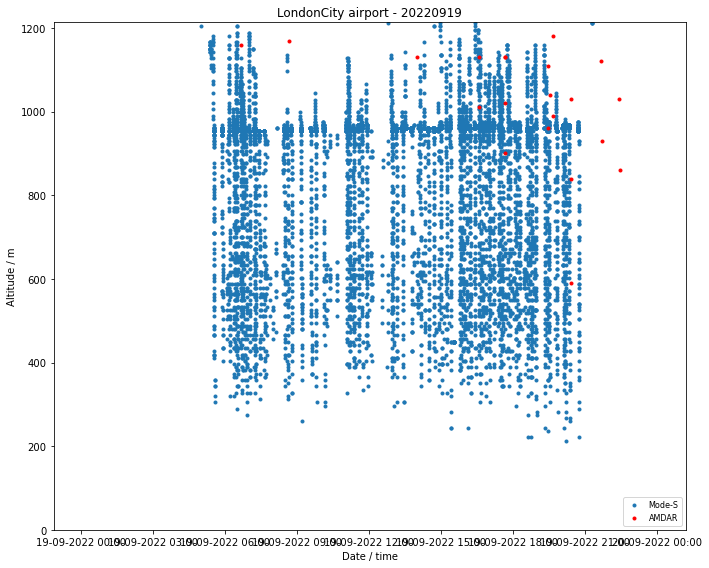

In [14]:
# Create data frame and plot altitude for individual days

for airport_name in airport_name_list:
    for date in date_list:
        
        data_amdar = create_dataframe(date, airport_name, select_runway_area, 'AMDARS')
        data_mode_s = create_dataframe(date, airport_name, select_runway_area, 'MODES')
        
        # Find mode_s min for plotting
        mode_s_min = data_mode_s['GNSS_ALTD'].min()
        y_max = mode_s_min + 1000
        
        # Plot data
    
        fig1, ax1 = plt.subplots(figsize=(10,8))
        plt.plot(data_mode_s['GNSS_ALTD'], marker='.', linestyle='None', label='Mode-S')
        plt.plot(data_amdar['ALTD'], marker='.', color='r', linestyle='None', label='AMDAR')
        ax1.set_xlabel('Date / time')
        ax1.set_ylabel('Altitude / m')
        plt.legend(loc='lower right', prop={'size':8})
        ax1.set_title('{0} airport - {1}'.format(airport_name, date))
        ax1.set_ylim([0, y_max])
        #ax1.set_xlim([datetime.datetime(2022, 9, 21,9,0,0), datetime.datetime(2022, 9, 21,9,30,0)])
        ax1.xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%Y %H:%M'))
        plt.tight_layout()
        #plt.savefig(os.path.join("D:/Mode-S_altitude/", "{0}_{1}.jpg".format(airport_name, date)))
        plt.show() 
        plt.close(fig1)

# 4. Plot altitude (multiple days)

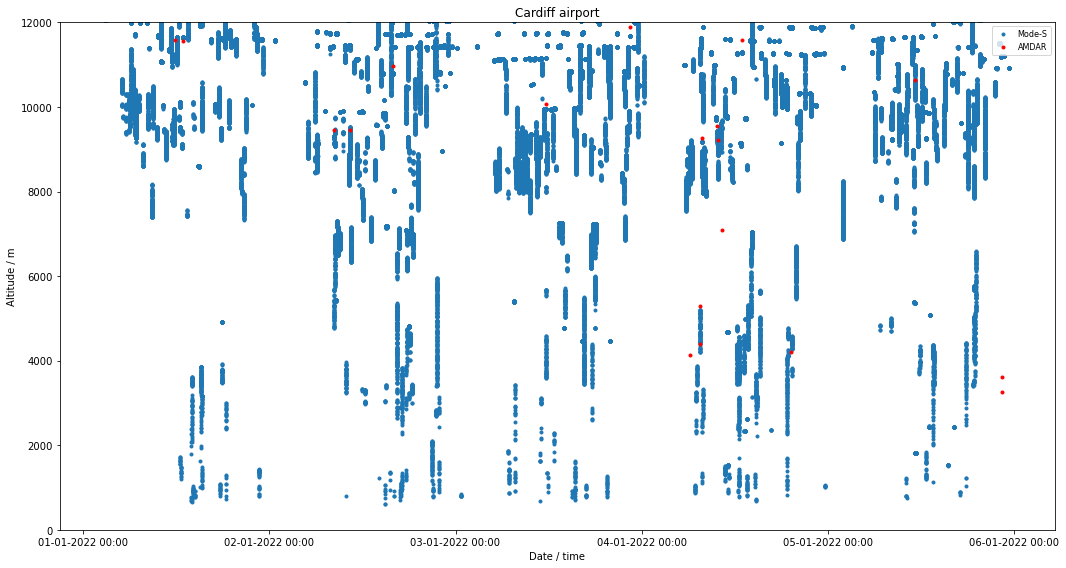

In [26]:
for airport_name in airport_name_list:
    
    concat_amdar = pd.DataFrame()
    concat_mode_s = pd.DataFrame()
    
    for date in date_list:

        data_amdar = create_dataframe(date, airport_name, select_runway_area, 'AMDARS')
        data_mode_s = create_dataframe(date, airport_name, select_runway_area, 'MODES')
                       
        concat_amdar = pd.concat([concat_amdar, data_amdar])
        concat_mode_s = pd.concat([concat_mode_s, data_mode_s])
        
        # Find mode_s min for plotting
        mode_s_min = data_mode_s['GNSS_ALTD'].min()
        y_max = mode_s_min + 1000
    
    # Plot data 
    
    fig1, ax1 = plt.subplots(figsize=(15,8))
    plt.plot(concat_mode_s['GNSS_ALTD'], marker='.', linestyle='None', label='Mode-S')
    plt.plot(concat_amdar['ALTD'], marker='.', color='r', linestyle='None', label='AMDAR')
    ax1.set_xlabel('Date / time')
    ax1.set_ylabel('Altitude / m')
    plt.legend(loc='upper right', prop={'size':8})
    ax1.set_title('{0} airport'.format(airport_name))
    #ax1.set_ylim([0, y_max])   
    ax1.set_ylim([0, 12000])  
    #ax1.set_xlim([datetime.datetime(2022, 9, 19,0,0,0), datetime.datetime(2022, 9, 20,0,0,0)])
    ax1.xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.tight_layout()
    plt.savefig(os.path.join("D:/Mode-S_altitude/", "{0}.jpg".format(airport_name)))
    plt.show() 
    plt.close(fig1)

# 5. Derive and plot hourly minimum altitude (multiple days)

242.12550149999998


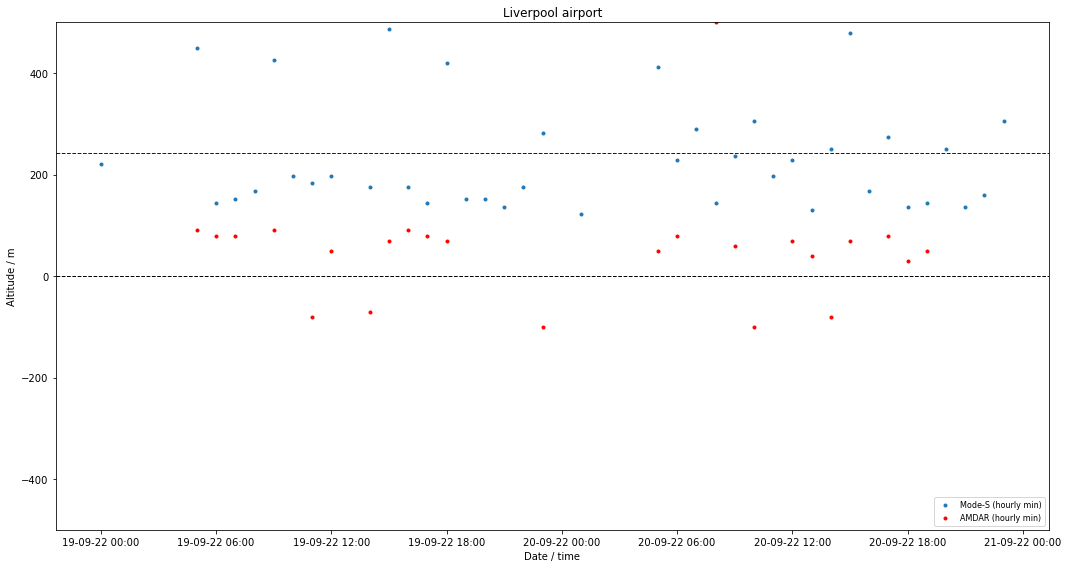

In [18]:
for airport_name in airport_name_list:
    
    concat_amdar = pd.DataFrame()
    concat_mode_s = pd.DataFrame()
    
    for date in date_list:

        data_amdar = create_dataframe_amdar(date, airport_name, select_runway_area)
        data_mode_s = create_dataframe_mode_s(date, airport_name, select_runway_area)
                       
        concat_amdar = pd.concat([concat_amdar, data_amdar])
        concat_mode_s = pd.concat([concat_mode_s, data_mode_s])     
    
    #Resample data and get hourly min altitude
    concat_amdar_hour = concat_amdar.resample('H').min()
    concat_mode_s_hour = concat_mode_s.resample('H').min()
    
    # Test removing high altitudes that result from no ascents/descents  
    concat_mode_s_hour.loc[concat_mode_s_hour['GNSS_ALTD'] > 2000, 'GNSS_ALTD'] = np.nan  
    
    mode_s_min_avg = concat_mode_s_hour['GNSS_ALTD'].mean()
    print(mode_s_min_avg)
   
    #diff = concat_amdar_hour['ALTD'] - concat_mode_s_hour['GNSS_ALTD']
    
    # Plot data 
    
    fig2, ax2 = plt.subplots(figsize=(15,8))
    plt.plot(concat_mode_s_hour['GNSS_ALTD'], marker='.', linestyle='None', label='Mode-S (hourly min)')
    plt.plot(concat_amdar_hour['ALTD'], marker='.', color='r', linestyle='None', label='AMDAR (hourly min)')
    #plt.plot(diff, marker='.', color='black', linestyle='-', label='AMDAR - Mode-S (hourly min)')
    ax2.set_xlabel('Date / time')
    ax2.set_ylabel('Altitude / m')
    plt.legend(loc='lower right', prop={'size':8})
    ax2.set_title('{0} airport'.format(airport_name))
    ax2.set_ylim([-500, 500])
            
    #ax2.set_xlim([datetime.datetime(2022, 9, 19,0,0,0), datetime.datetime(2022, 9, 20,0,0,0)])
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y %H:%M'))
    ax2.axhline(y=0, xmin=0, xmax=1, linewidth =1, linestyle = '--', color='black')
    ax2.axhline(y=mode_s_min_avg, xmin=0, xmax=1, linewidth =1, linestyle = '--', color='blue')
    plt.tight_layout()
    plt.savefig(os.path.join("D:/Mode-S_altitude/", "{0}_hour_min_altd.jpg".format(airport_name)))
    plt.show() 
    plt.close(fig2)